### 수치형 변수 요약
- 오른쪽으로 치우친 분포는 대다수의 관측값이 0이기 때문에 수치형 변수로는 SalePrice와 관계가 있는지 파악하기 어렵다. 따라서 범주형 변수로 변환하여 SalePrice와 관련이 있는지 확인할 필요성이 있다.

    - PoolArea, LowQualFinSF, 3SsnPorch, MiscVal, ScreenPorch, BsmtFinSF2, EnclosedPorch

- YearRemodAdd 변수는 년도가 증가함에 따라 SalePrice의 가격은 점차 증가하는 추세로써 SalePrice에 중요한 요인으로 보인다.

- SalePrice와 관련있는 변수들 중 1차 회귀선에 적합하지 않는 변수들이 존재한다. 따라서 변수 변환 작업이 필요해 보인다.

    - YearBuilt, GarageYrBlt

- SalePrice와 강한 양의 상관관계를 가지고 있는 변수들이 있는 반면, 약한 양의 상관관계를 가지는 변수들도 존재한다.

    - 강한 상관관계: LotFrontage, TotalBsmtSF, 1stFlrSF, GrLivArea, GarageArea

    - 약한 상관관계: BsmtFinSF1, MasVnrArea

- 2ndFlrSF 변수는 SalePrice와 약한 양의 상관관계로 fitting 되어 있지만, 대다수의 관측값이 0으로 치우쳐 있기 때문에 fitting이 잘 되어있지 않다.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import probplot, skew
from scipy.special import boxcox1p

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

pd.options.display.max_rows = 300

import warnings
warnings.filterwarnings('ignore')

# plt.style.use('seaborn')

In [2]:
train = pd.read_csv('C:\\Users\\이찬영\\Desktop\\House_Price\\train.csv',index_col= 0)
test = pd.read_csv('C:\\Users\\이찬영\\Desktop\\House_Price\\test.csv',index_col = 0)

In [3]:
house_df = pd.concat([train,test], axis = 0)

In [4]:
numerical_features = []
categorical_features = []

for feature in house_df.columns:
    if house_df[feature].dtypes == 'O':
        categorical_features.append(feature)
    else:
        numerical_features.append(feature)

### 수치형 타입 확인
- 수치형으로 된 타입을 기준으로 'SalePrice'의 관계를 살펴봤으나 "MSSubClass", "OverallQual" 등의 변수가 범주형 타입으로 존재

- 따라서 아래의 시각화를 통해 수치형과 범주형을 재정의한 후, SalePrice와의 관계를 다시 살펴보기로 결정
    - 범주형: 'MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold'

    - 수치형: 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal'

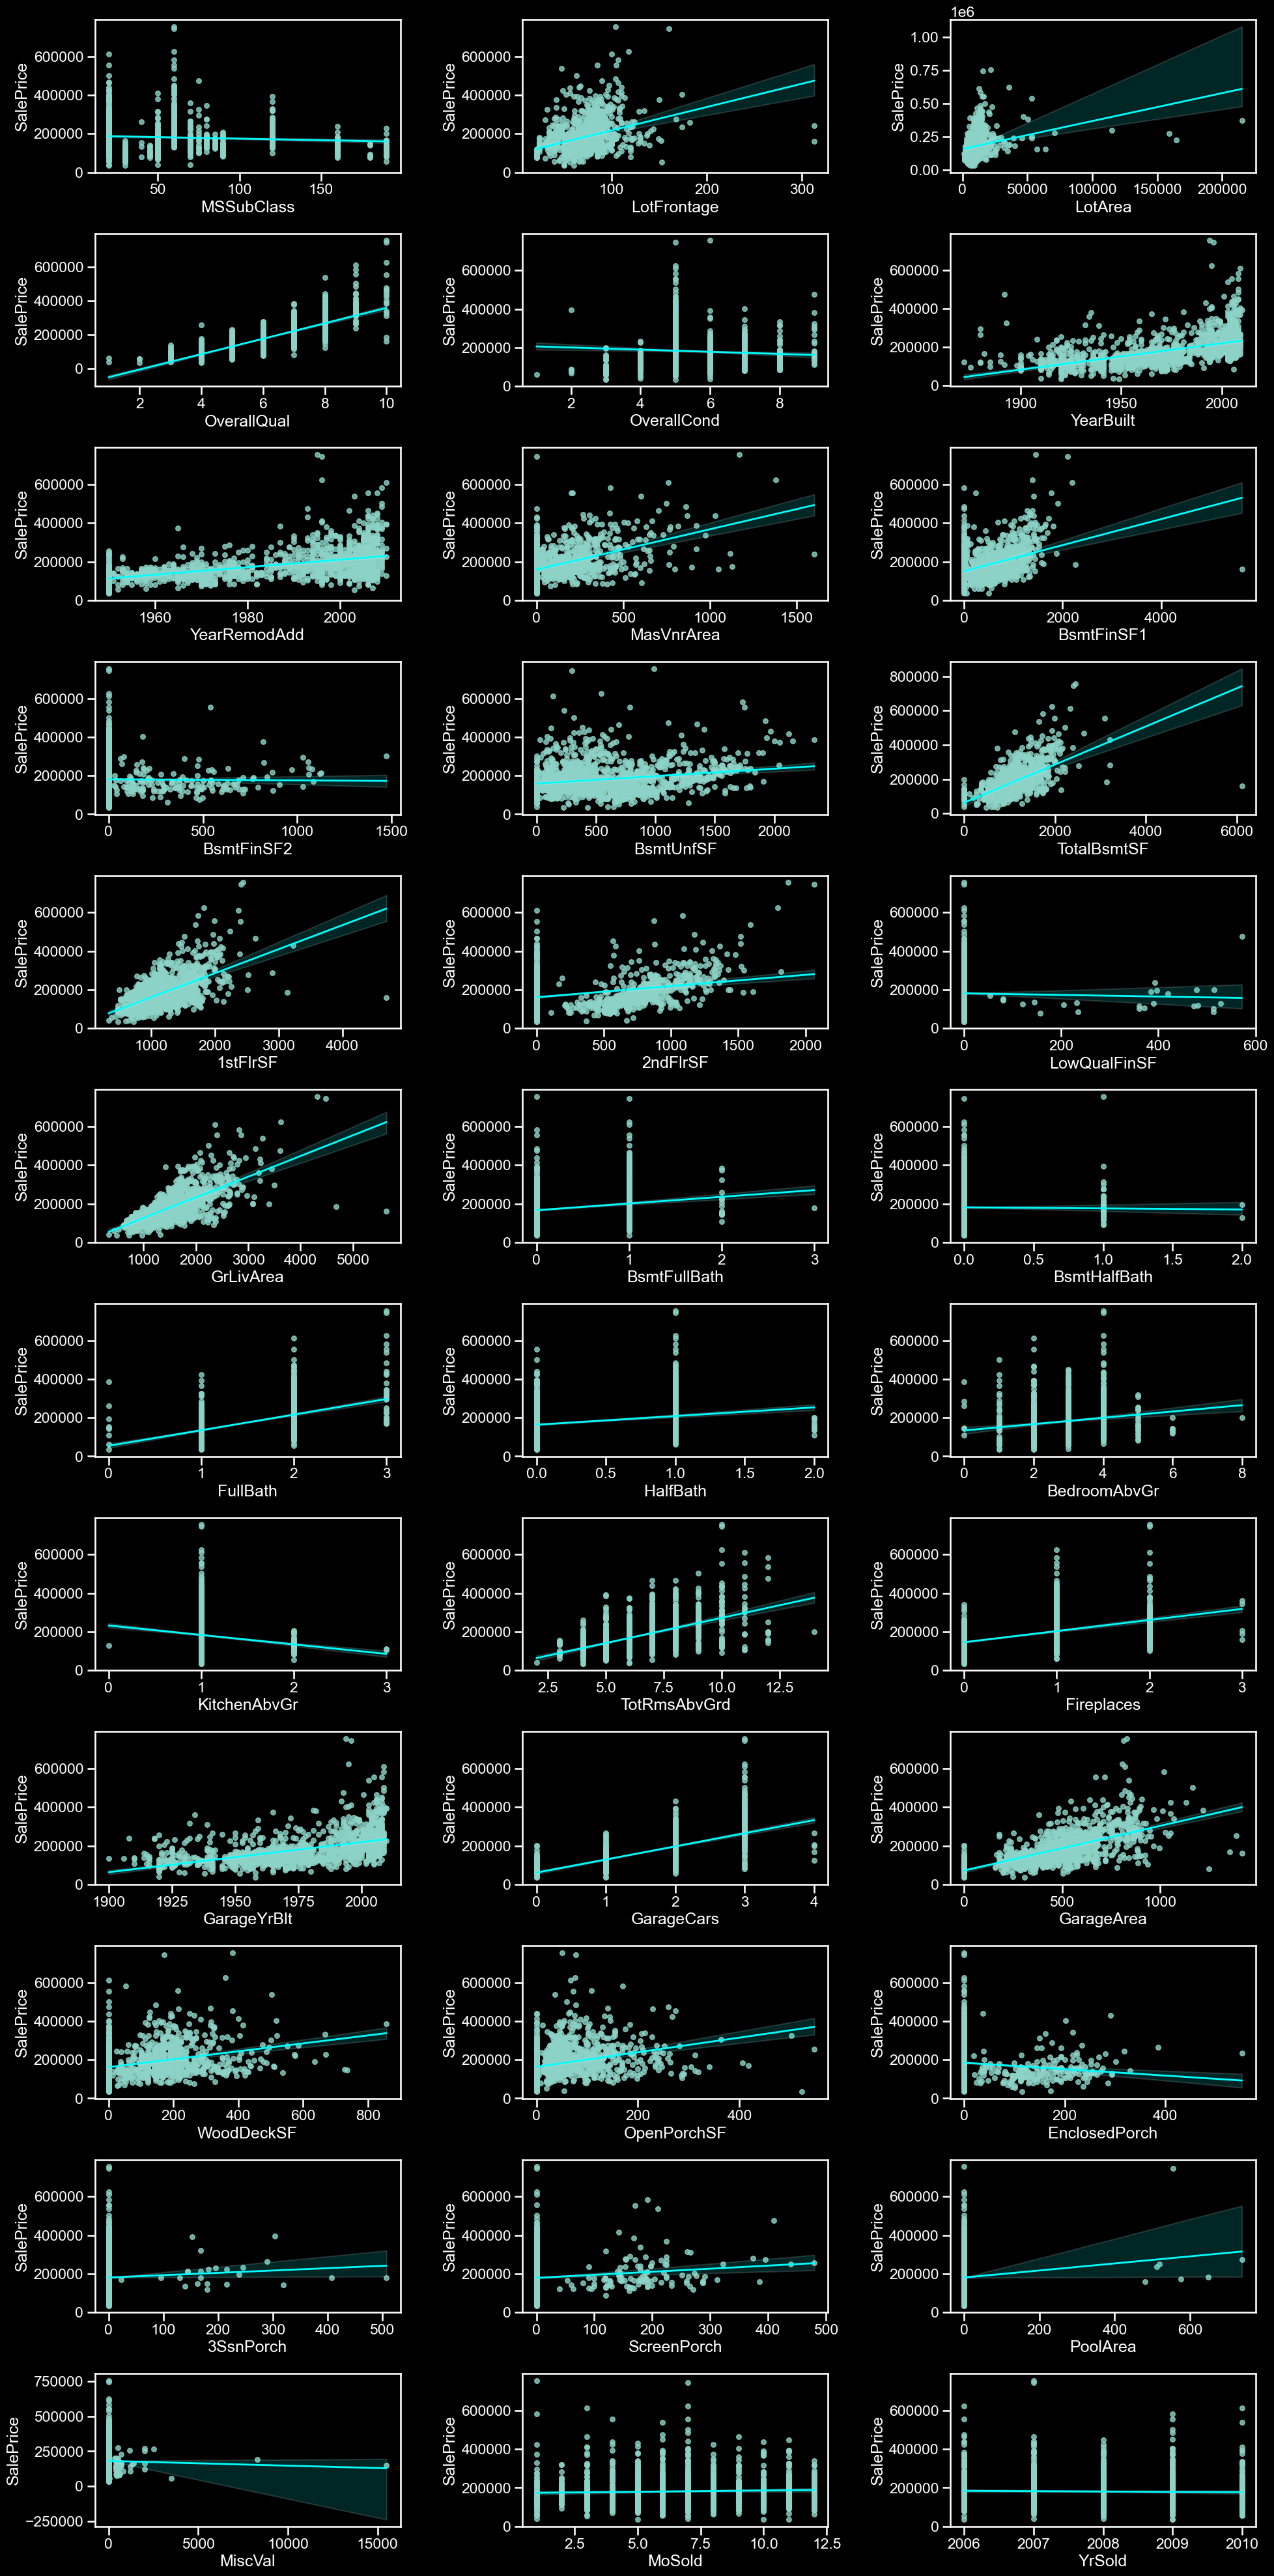

In [5]:
marker_size = 30
i = 1
sns.set(style = 'ticks', context = 'talk', font_scale= 1)
plt.style.use("dark_background")
plt.figure(figsize=(23, 50))

plt.subplots_adjust( hspace = 0.4, wspace= 0.4)

for feature in numerical_features[:-1]:
    plt.subplot(12,3,i)
    sns.regplot(data = house_df, x = feature, y = 'SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2})
    i += 1

In [6]:
cat_to_num = ['MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']

for col in house_df.columns:
    if col in cat_to_num:
        house_df[col] = house_df[col].astype('O')

In [7]:
# categorical_features = ['BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure', 
#                         'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 
#                         'CentralAir', 'Condition1', 'Condition2', 'Electricalf, 'ExterCond', 
#                         'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 
#                         'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageCars', 
#                         'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'HalfBath', 
#                         'Heating', 'HeatingQC', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 
#                         'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 
#                          'MiscFeature', 'Neighborhood', 'OverallCond', 
#                         'OverallQual', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 
#                         'SaleCondition', 'SaleType', 'Street', 'TotRmsAbvGrd', 'Utilities', 'HouseStyle']


# numerical_features = ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2', 
#                       'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GrLivArea', 
#                       'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 
#                       'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF']

# temporal_features = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold', 'GarageYrBlt']

In [8]:
# categorical_features = list(set(categorical_features) - set(['FireplaceQu', 'Fence', 'MiscFeature', 'PoolQC'])) # 'Alley'

In [9]:
numerical_features = []
categorical_features = []

for feature in house_df.columns:
    if house_df[feature].dtypes == 'O':
        categorical_features.append(feature)
    else:
        numerical_features.append(feature)

### 타입 수정 후, 수치형 변수 분포 확인
- 0에 치우친 분포들이 다수 존재한다.
    
    - MasVnrArea, BsmtFinSF1, BsmtFinSF2, 2ndFlrSF, LowQualFinSF, GarageYrBlt, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal

    - 위 변수들은 범주형 변수로 새롭게 생성한 후, SalePrice와 관계를 다시 살펴볼 필요성이 있다.

- 오른쪽으로 치우친 분포들이 존재한다.

    - LotArea, MasVnrArea, BsmtFinSF2 etc...

    - 위 분포를 통해서 정확한 수치를 파악하기 어려우므로 skew 의 값을 통해 다시 확인할 필요가 있다.

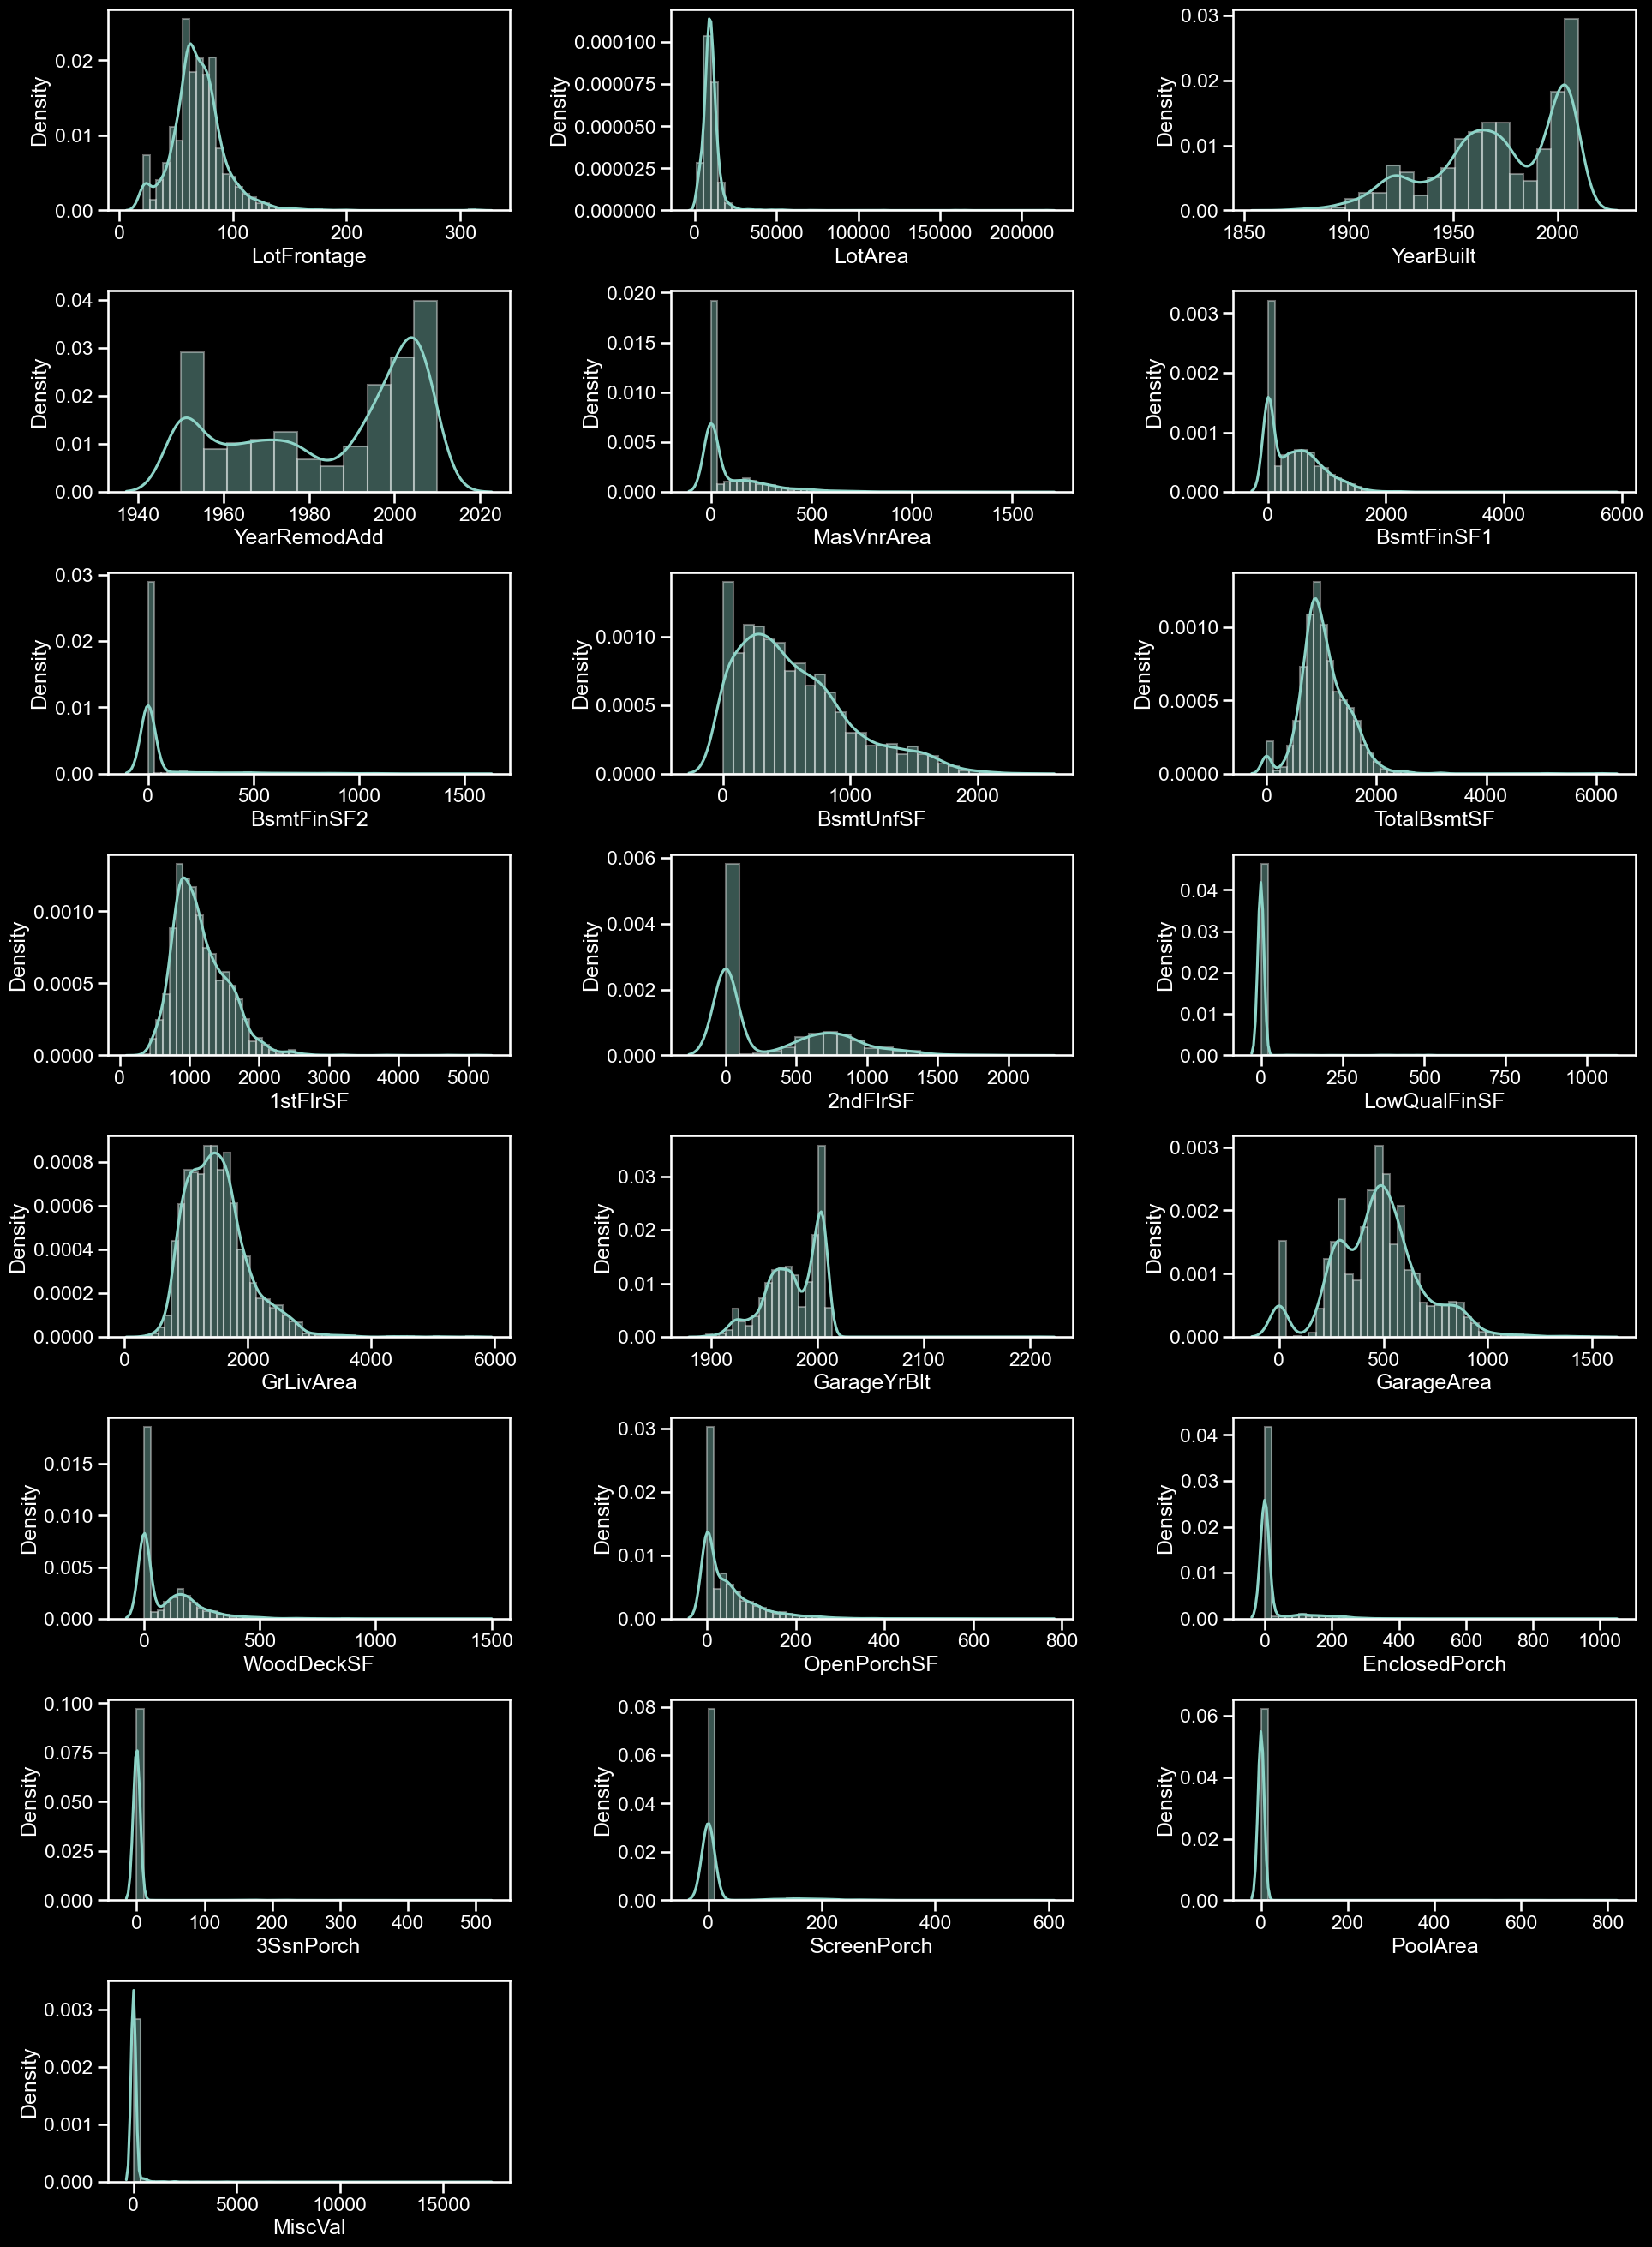

In [10]:
i = 1
sns.set(style='ticks', context = 'talk', font_scale = 1)
plt.style.use('dark_background')
plt.figure(figsize = (23,50))

plt.subplots_adjust( hspace = 0.4, wspace = 0.4)

for feature in numerical_features[:-1]:
    plt.subplot(12,3,i)
    sns.distplot(house_df[feature])
    i += 1

#### Skewness Check
- skew 값이 1보다 큰 변수의 개수는 13개이다.

- 13개의 변수는 모두 오른쪽으로 치우쳐 있으므로 Log 변환 후 Skew 수치에 변화가 있는지 확인이 필요하다.

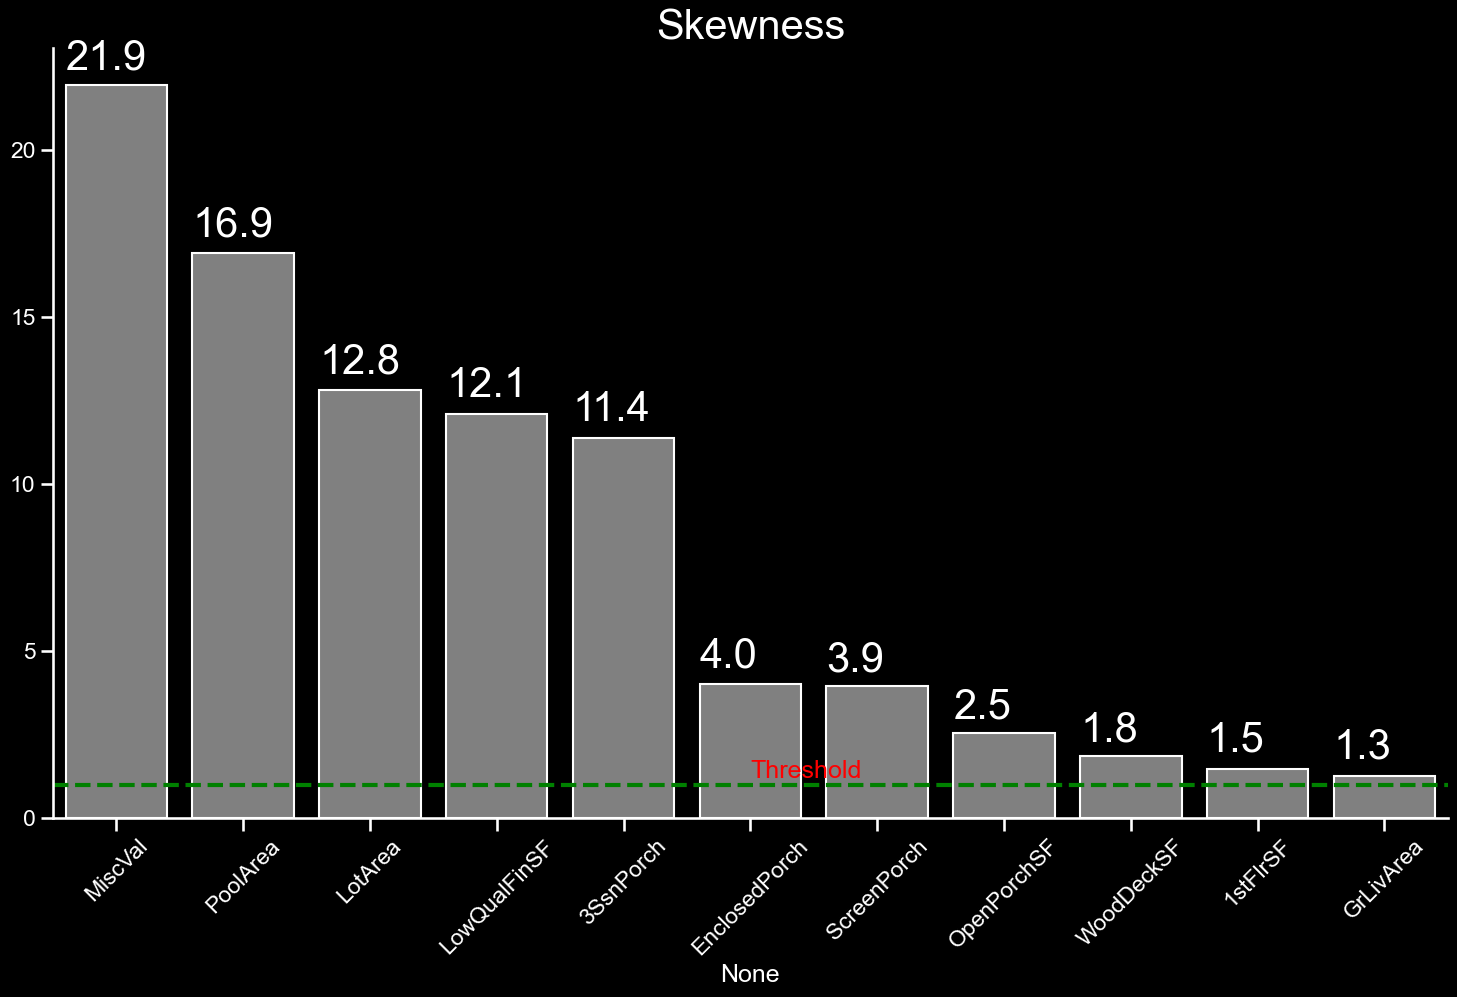

In [11]:
from scipy.stats import skew
plt.figure(figsize = (18, 10))
skew_features = house_df[numerical_features].apply(lambda x: skew(x))
skew_features = skew_features[skew_features > 1].sort_values(ascending = False)

ax = sns.barplot( x = skew_features.index, y = skew_features.values, color = 'grey')
for p in ax.patches:
    height = p.get_height().round(1)
    ax.text(p.get_x() + p.get_width() // 2, height + 0.5, height, ha = 'left', size = 30)

plt.xticks(rotation = 45)
plt.text(5, 1.2, 'Threshold', color = 'red')
plt.axhline( y = 1, color = 'green', linestyle = '--', linewidth = 3)
plt.title('Skewness', fontsize = 30)
sns.despine()

#### Log Transform Skewness Check
- 로그 변환 후, 오른쪽으로 치우친 분포는 13개에서 7개의 변수로 줄어들었다.

    - PoolArea, LowQualFinSF, 3SsnPorch, MiscVal, ScreenPorch, BsmtFinSF2, EnclosedPorch

- 남겨진 7개의 변수는 0에 치우쳐 있는 분포들이기 때문에 수치형으로도 적합하지 않는 변수로 판단되므로 범주형 변수로 변환하여 SalePrice의 영향이 있는지 확인 작업이 필요하다.

In [12]:
house_df[skew_features.index] = np.log1p(house_df[skew_features.index])

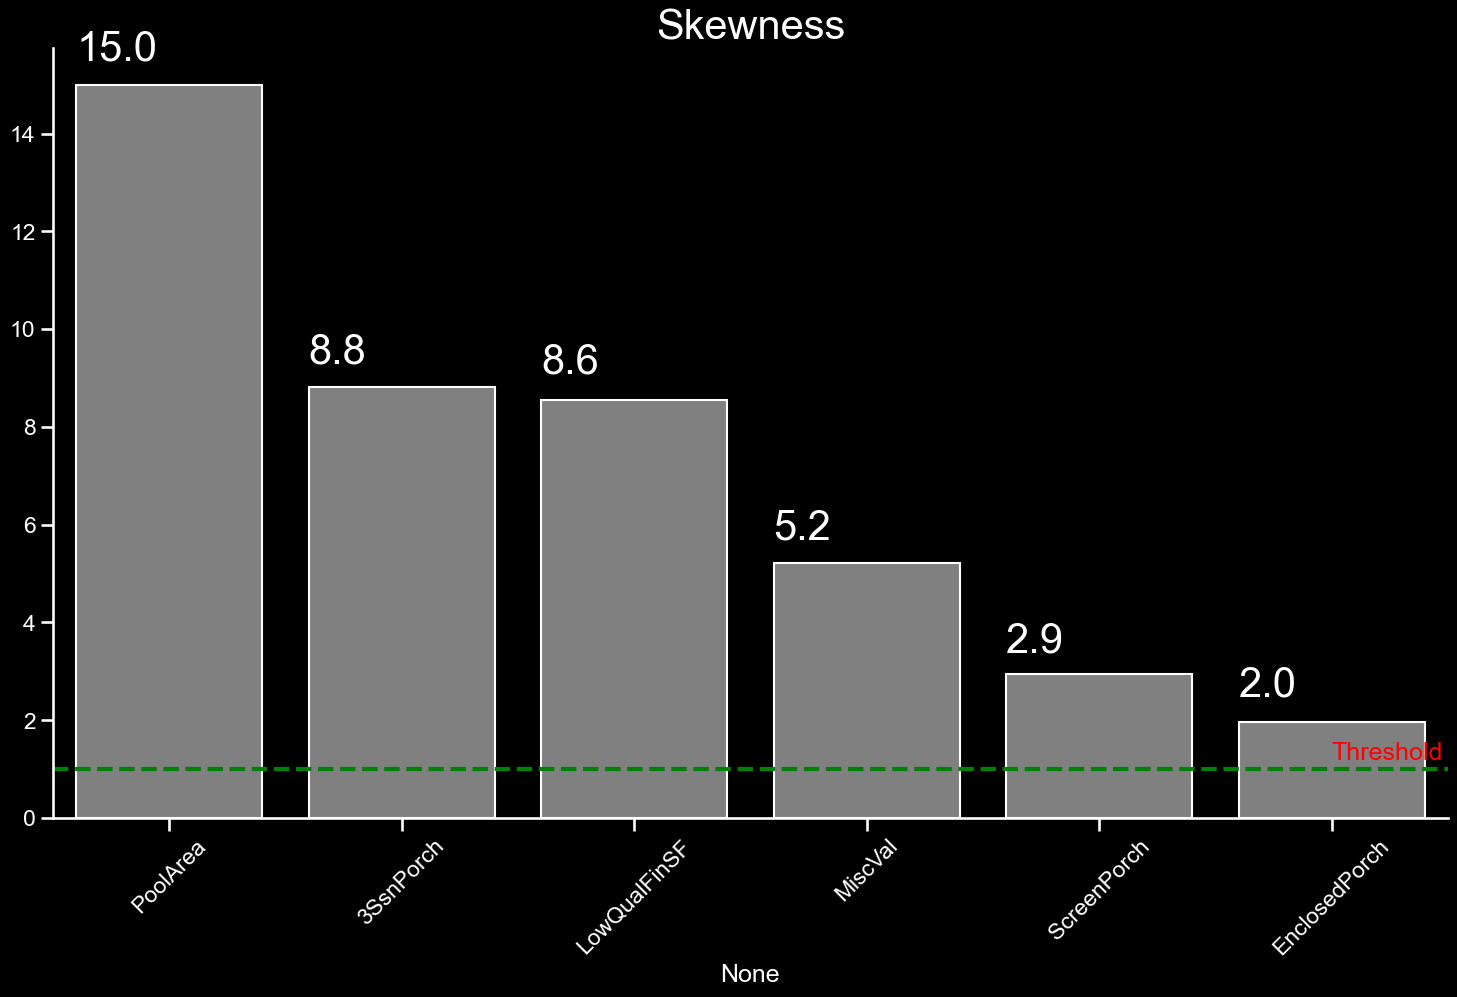

In [13]:
from scipy.stats import skew
plt.figure(figsize = (18, 10))
skew_features = house_df[numerical_features].apply(lambda x: skew(x))
skew_features = skew_features[skew_features > 1].sort_values(ascending = False)

ax = sns.barplot( x = skew_features.index, y = skew_features.values, color = 'grey')
for p in ax.patches:
    height = p.get_height().round(1)
    ax.text(p.get_x() + p.get_width() // 2, height + 0.5, height, ha = 'left', size = 30)

plt.xticks(rotation = 45)
plt.text(5, 1.2, 'Threshold', color = 'red')
plt.axhline( y = 1, color = 'green', linestyle = '--', linewidth = 3)
plt.title('Skewness', fontsize = 30)
sns.despine()

In [14]:
house_df["Have_PoolArea"] = (house_df.PoolArea>0).astype("O")
house_df["Have_LowQualFinSF"] = (house_df.LowQualFinSF>0).astype("O")
house_df["Have_3SsnPorch"] = (house_df['3SsnPorch']>0).astype("O")
house_df["Have_MiscVal"] = (house_df.MiscVal>0).astype("O")
house_df["Have_ScreenPorch"] = (house_df.ScreenPorch>0).astype("O")
house_df["Have_BsmtFinSF2"] = (house_df.BsmtFinSF2>0).astype("O")
house_df["Have_EnclosedPorch"] = (house_df.EnclosedPorch>0).astype("O")

### 타입 수정 후, 수치형 변수 관계 재확인
- YearBuilt, YearRemodAdd 등의 변수는 SalePrice와 관계가 있는 것으로 보이나 1차 회귀선에 적합해 보이지 않는다.

- 1차 회귀식(양의 상관관계)에 적합한 변수들이 존재하지만, 이분산성 다소 존재하기 때문에 분산을 최소화 해주는 작업이 필요해 보인다.
    - LotFrontage, MasVnrArea, BsmtFinSF1, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, GrLivArea, GarageArea, WoodDeckSF, OpenPorchSF

- GarageYrBlt는 범주형 변수는 아니지만, 값이 좌 우로 치우쳐 있기 때문에 0을 제외하고 다시 살펴봐야 될 것으로 보인다.

- 그 외 변수들은 0 값에 주로 분포되어 있고, SalePrice에 큰 영향을 미치지 못하기 때문에 모델링에 적합하지 않을 것으로 보인다.
    - 3SanPorch, EnclosedPorch, ScreenPorch, PoolArea, MiscVal

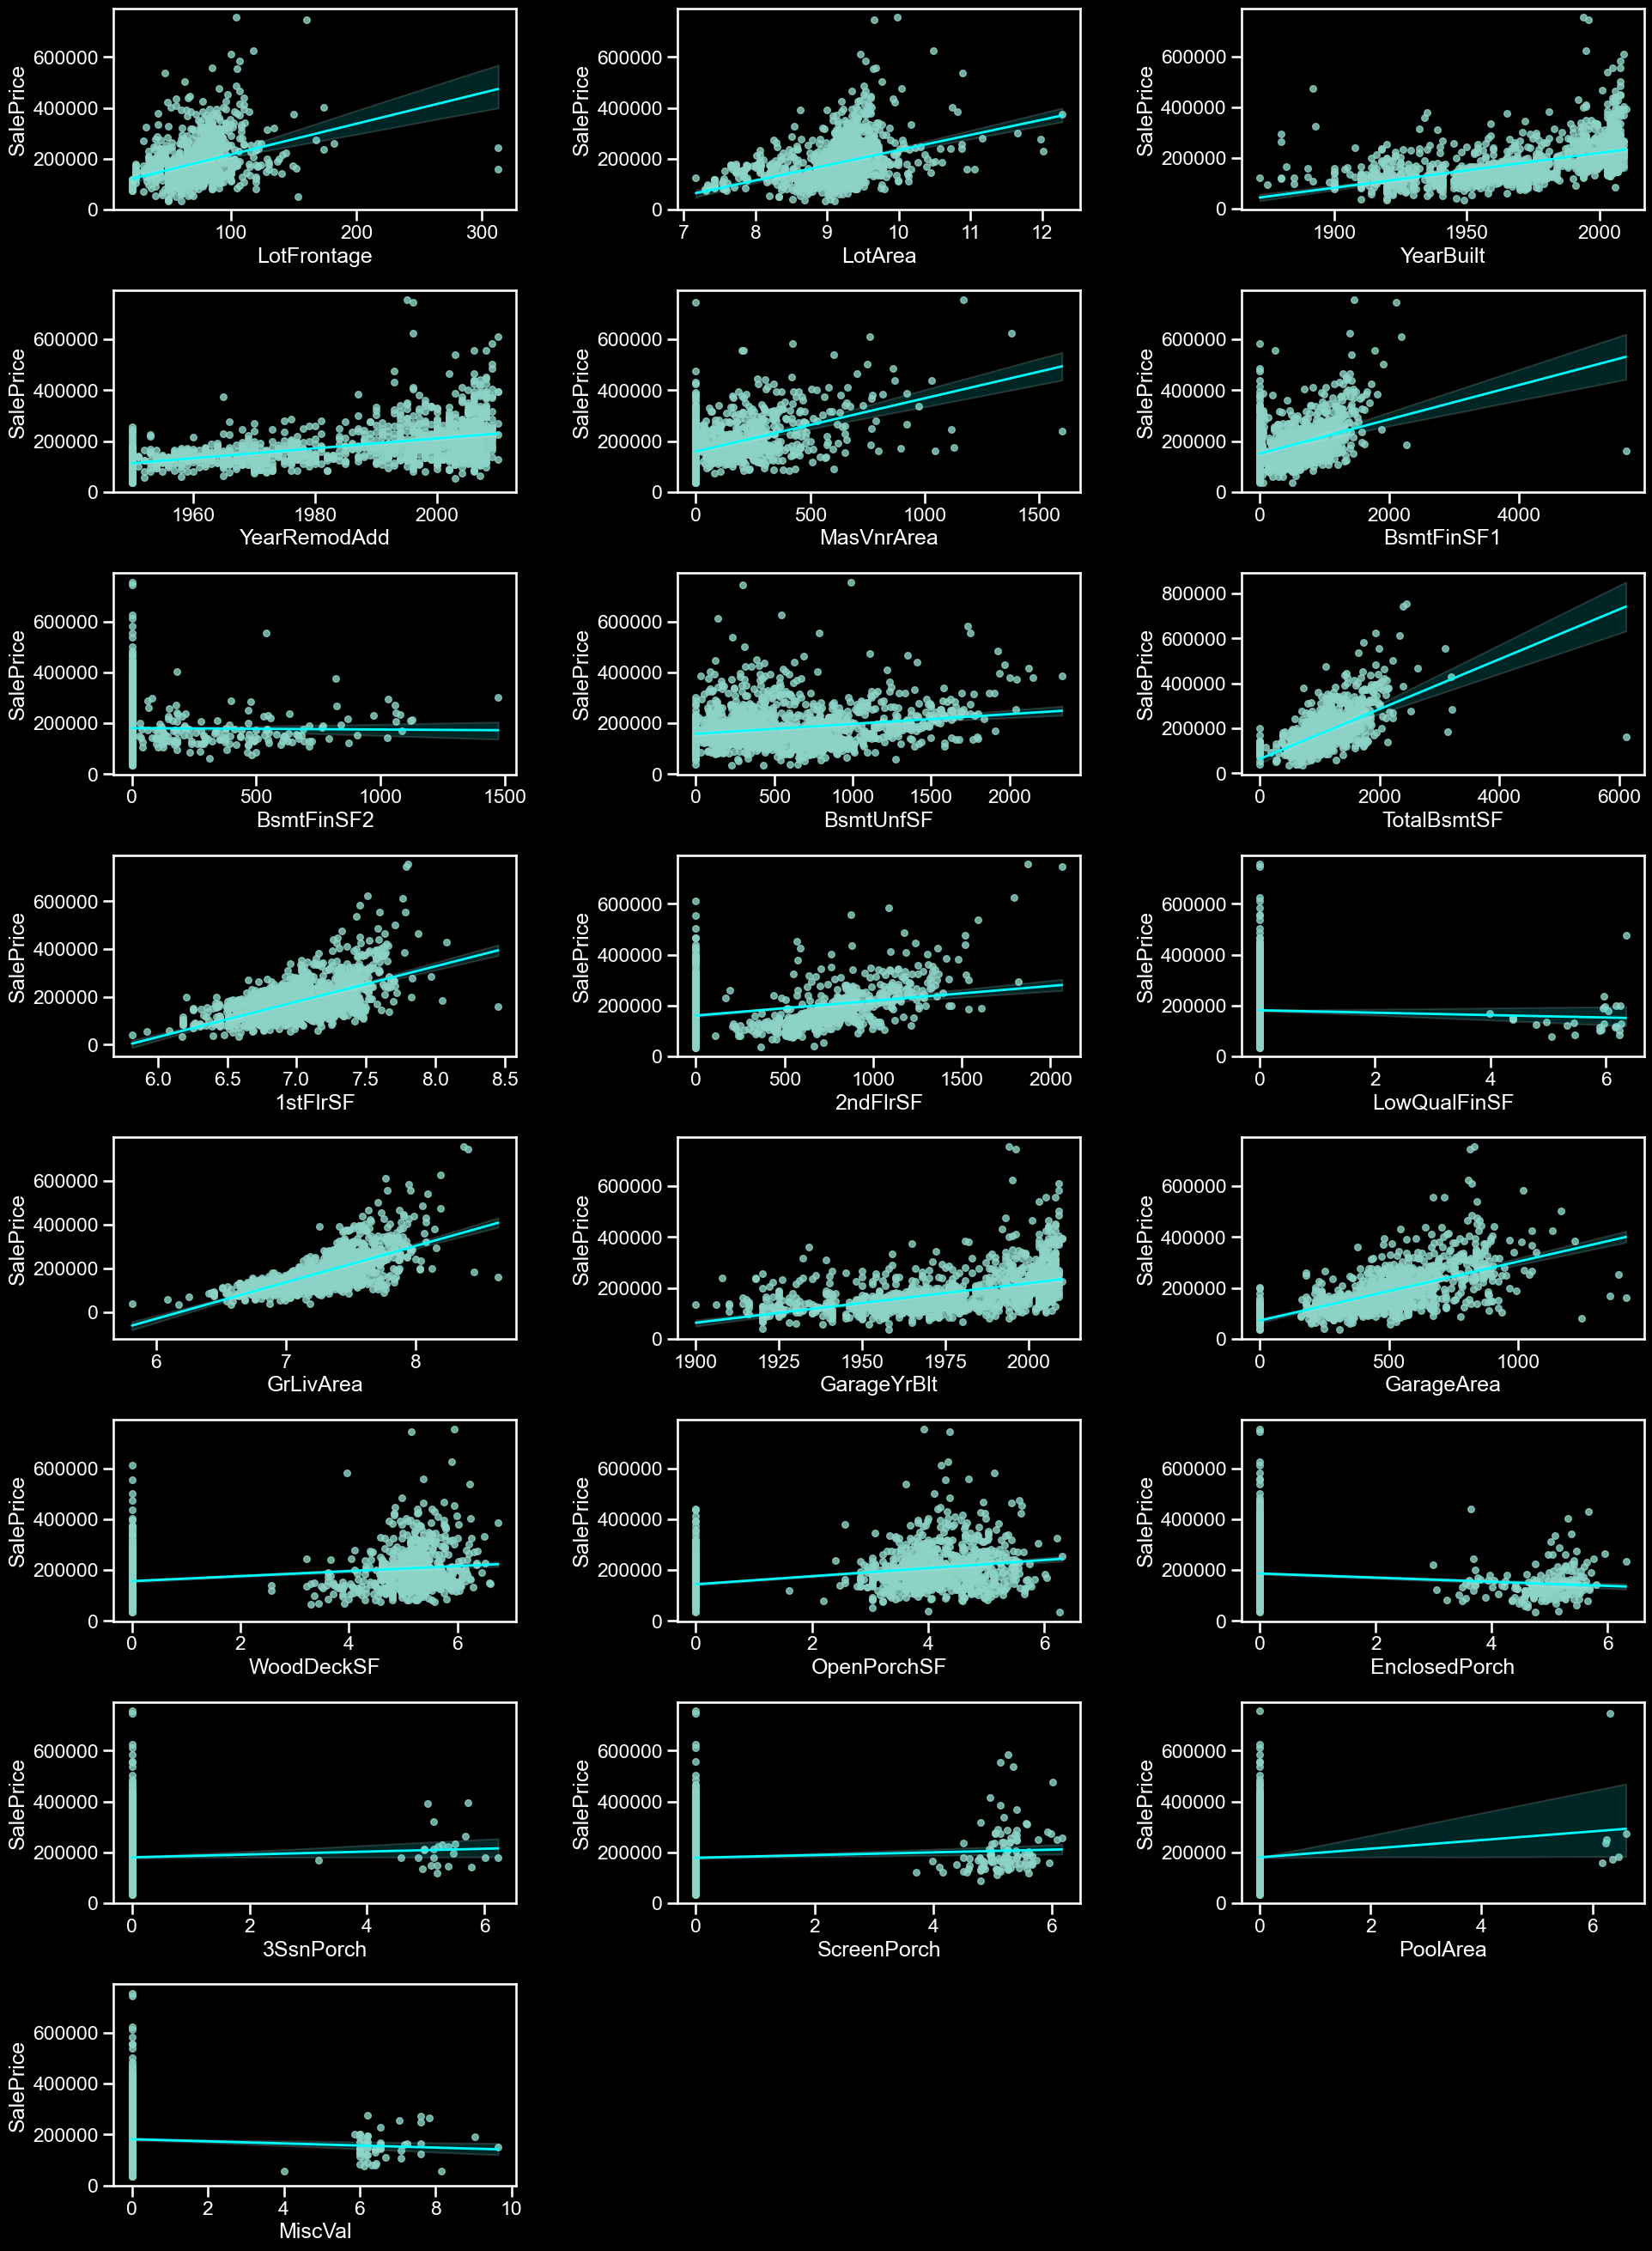

In [15]:
marker_size = 30
i = 1
sns.set(style = 'ticks', context = 'talk', font_scale= 1)
plt.style.use("dark_background")
plt.figure(figsize=(23, 50))

plt.subplots_adjust( hspace = 0.4, wspace= 0.4)

for feature in numerical_features[:-1]:
    plt.subplot(12,3,i)
    sns.regplot(data = house_df, x = feature, y = 'SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2})
    i += 1

#### Detailed Numerical features

- YearBuilt & GarageYrBlt

    - 1차 회귀선보다 2차 회귀선이 더 적합해보인다.

    - 1920년대 이후로 최근에 지어질수록 집의 가격(SalePrice)이 상승하는 추세를 보인다.

In [16]:
house_df['Log_SalePrice'] = np.log1p(house_df['SalePrice'])

<Axes: xlabel='GarageYrBlt', ylabel='Log_SalePrice'>

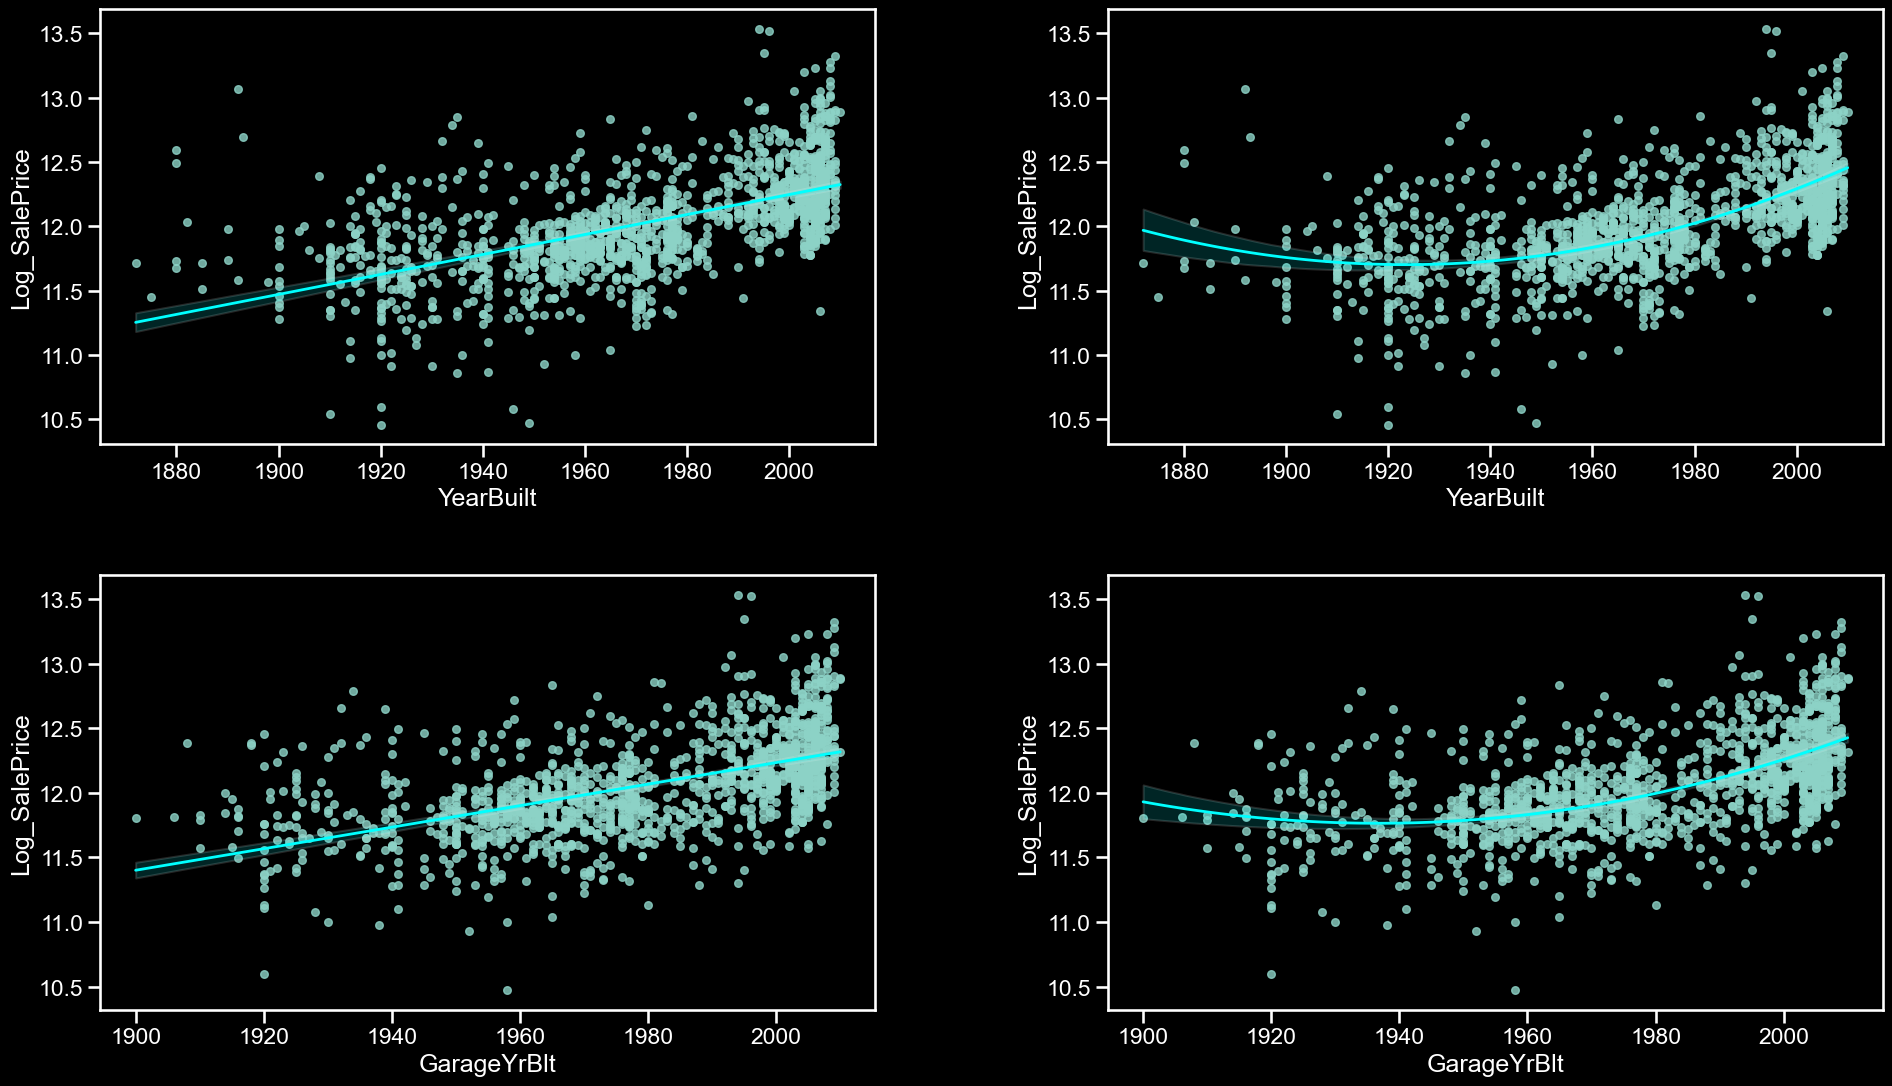

In [17]:
marker_size = 30
sns.set(style = 'ticks', context = 'talk', font_scale= 1)
plt.style.use("dark_background")

plt.figure(figsize=(23, 13))
plt.subplots_adjust(hspace = 0.3, wspace= 0.3)

plt.subplot(2,2,1)
sns.regplot(data = house_df, x = 'YearBuilt', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2})

plt.subplot(2,2,2)
sns.regplot(data = house_df, x = 'YearBuilt', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2},order = 2)

plt.subplot(2,2,3)
sns.regplot(data = house_df[house_df['GarageYrBlt'] > 0], x = 'GarageYrBlt', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2})

plt.subplot(2,2,4)
sns.regplot(data = house_df[house_df['GarageYrBlt'] > 0], x = 'GarageYrBlt', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2},order = 2)

- YearRemodAdd

    - 시간이 갈수록 점점 더 가격이 증가하는 추세를 보인다.

<Axes: xlabel='YearRemodAdd', ylabel='Log_SalePrice'>

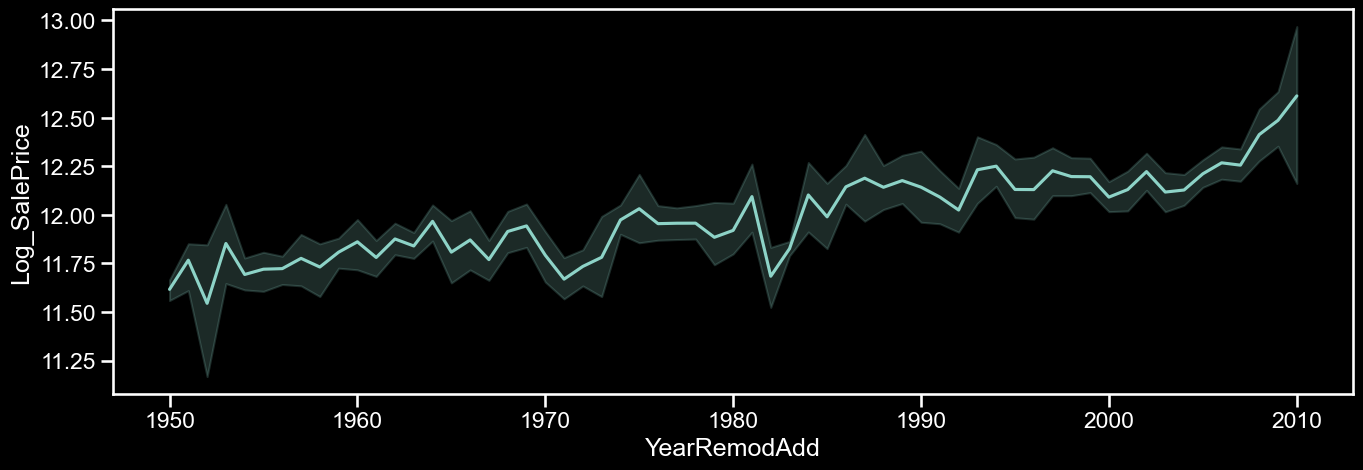

In [18]:
plt.figure(figsize=(16, 5))
sns.lineplot(data=house_df, x='YearRemodAdd',y='Log_SalePrice')

- LotFrontage

    - 집의 가격은 부동산의 거리와도 관계가 있는 것으로 보인다.

<Axes: xlabel='LotFrontage', ylabel='Log_SalePrice'>

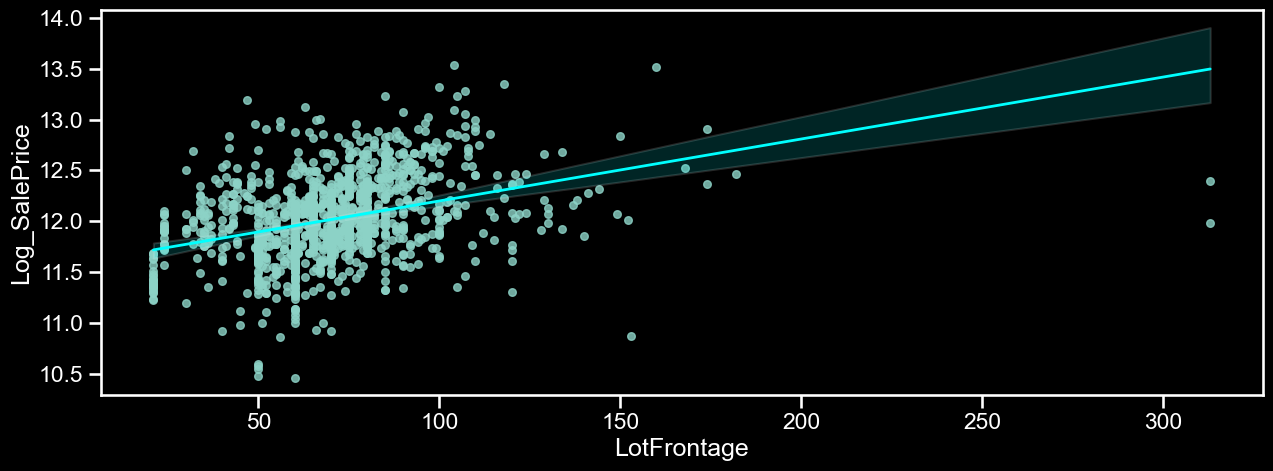

In [19]:
marker_size = 30
sns.set(style = 'ticks', context = 'talk', font_scale= 1)
plt.style.use("dark_background")

plt.figure(figsize=(15, 5))

sns.regplot(data = house_df, x = 'LotFrontage', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2}, order = 1)

- TotalBsmtSF & BsmtFinSF1 & BsmtFinSF2 & BsmtUnfSF

    - 4개의 변수는 모두 지하실에 해당하는 면적을 의미하므로 파생변수를 생성하여 SalePrice의 관계를 다시 살펴볼 필요성이 있다.
    
    - TotalBsmtSF 와 SalePrice는 강한 상관관계에 있다.

    - (BsmtFinSF1, BsmtUnfSF) 와 SalePrice는 약한 상관관계에 있다.

    - 대부분의 집에서 BsmtFinSF2가 0의 값으로 존재하며, 0을 제외하고 SalePrice의 관계를 살펴봤을 때 영향이 거의 없는 것으로 보인다.

<Axes: xlabel='BsmtUnfSF', ylabel='Log_SalePrice'>

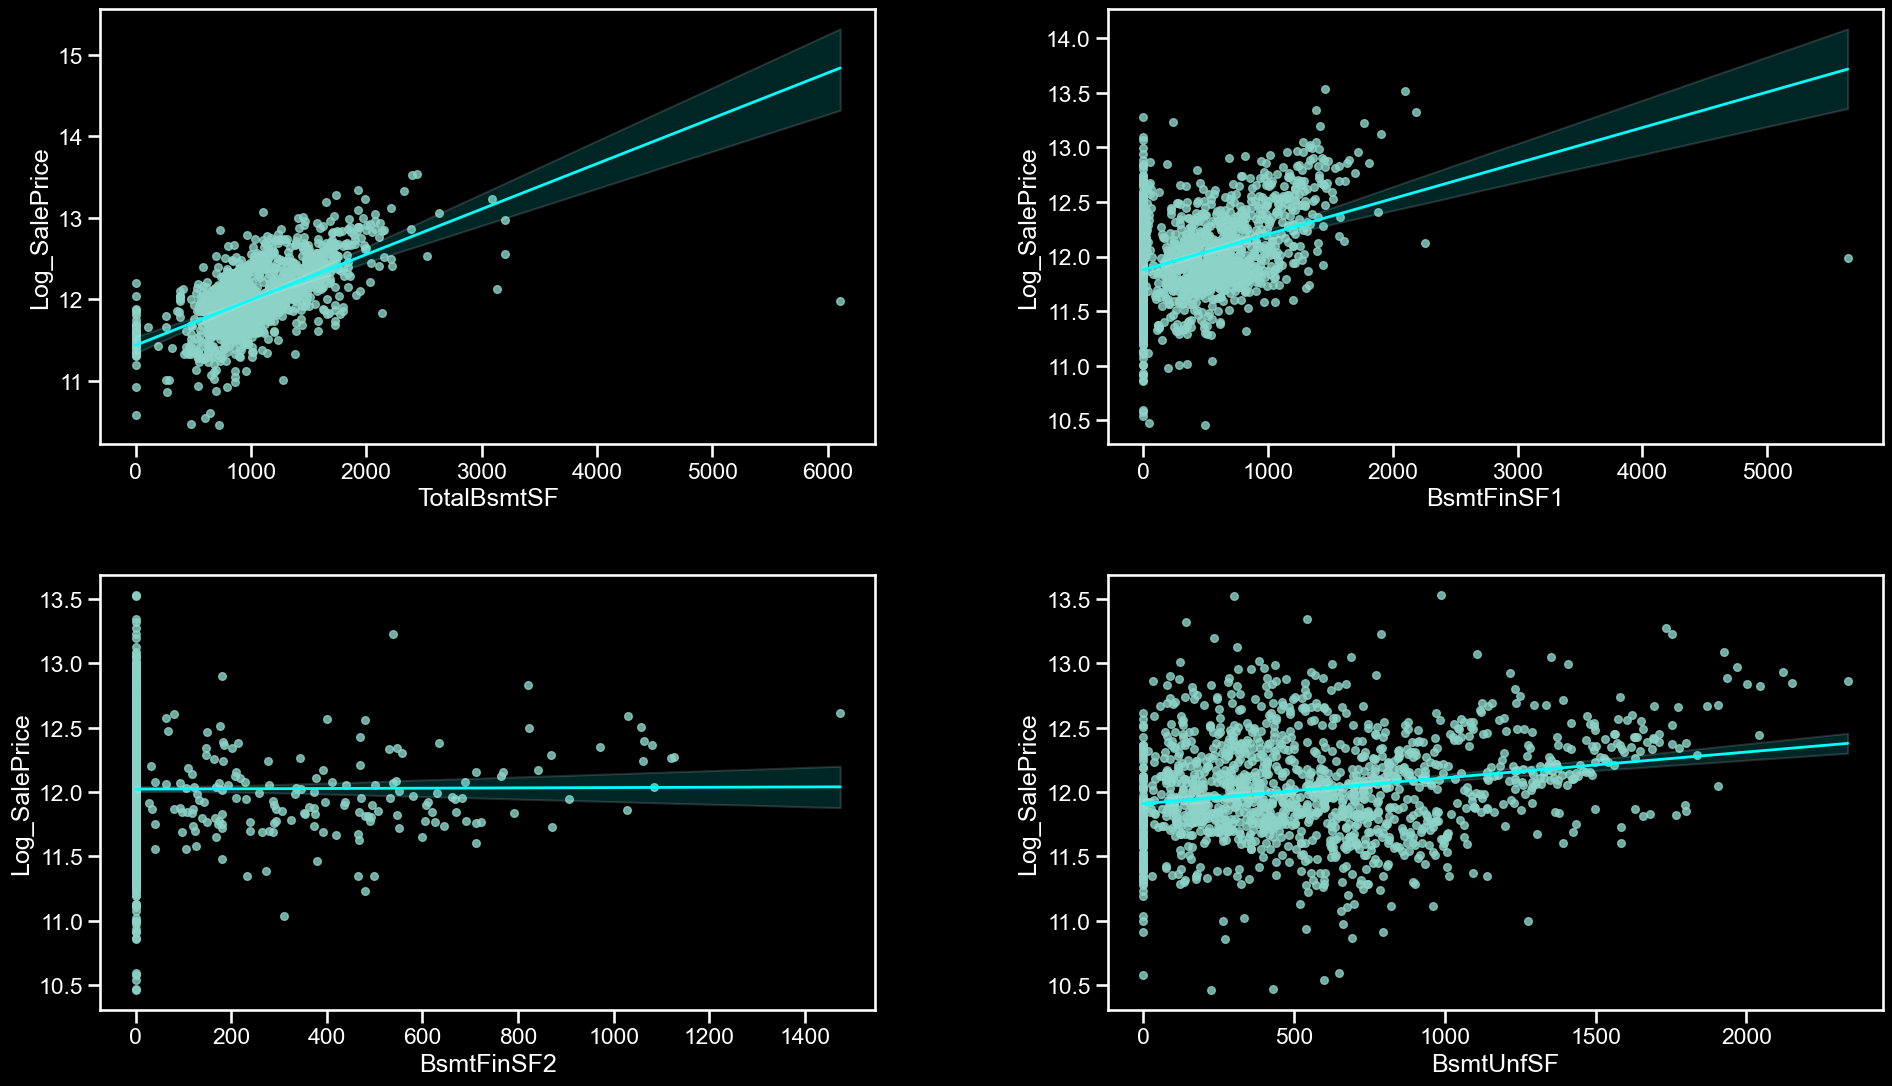

In [20]:
marker_size = 30
sns.set(style = 'ticks', context = 'talk', font_scale= 1)
plt.style.use("dark_background")

plt.figure(figsize=(23, 13))
plt.subplots_adjust(hspace = 0.3, wspace= 0.3)

plt.subplot(2,2,1)
sns.regplot(data = house_df, x = 'TotalBsmtSF', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2}, order =1)

plt.subplot(2,2,2)
sns.regplot(data = house_df, x = 'BsmtFinSF1', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2}, order =1)

plt.subplot(2,2,3)
sns.regplot(data = house_df, x = 'BsmtFinSF2', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2}, order =1)

plt.subplot(2,2,4)
sns.regplot(data = house_df, x = 'BsmtUnfSF', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2}, order =1)

- 1stFlrSF & 2ndFlrSF

    - 1stFlrSF는 SalePrice와 강한 상관관계가 있다.

    - 2ndFlrSF는 회귀선에 적합해보이지 않는다. 대다수의 관측값에서 0의 값을 가지고 있기 때문에 fitting이 잘 안되는 것으로 보인다.

<Axes: xlabel='2ndFlrSF', ylabel='Log_SalePrice'>

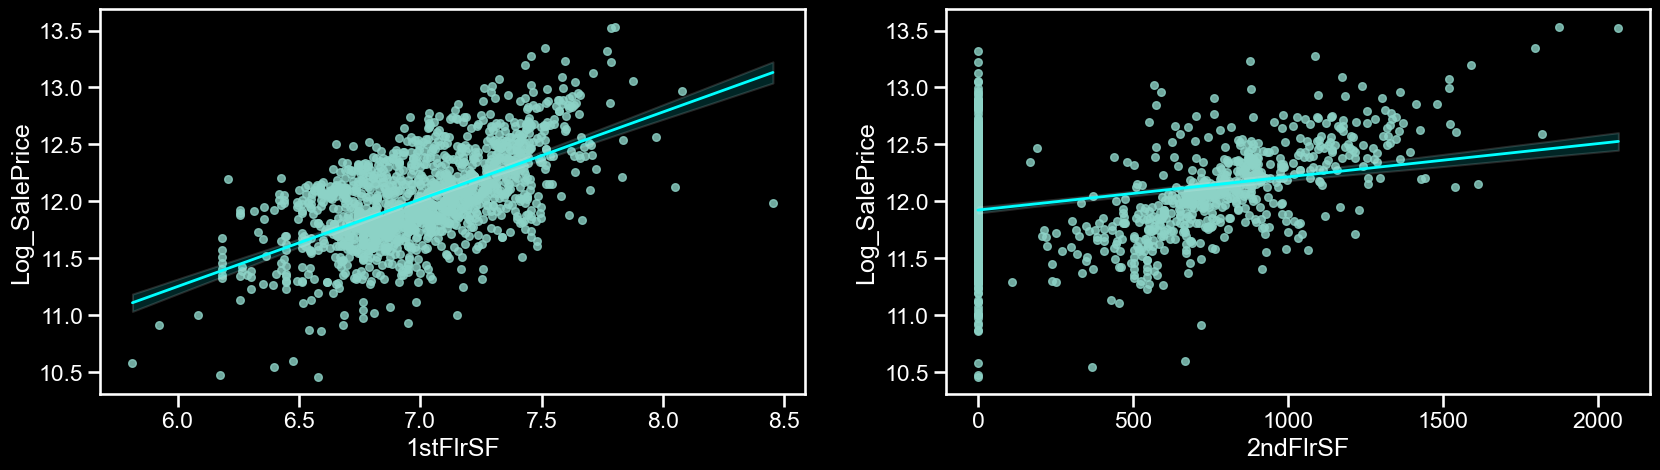

In [21]:
marker_size = 30
sns.set(style = 'ticks', context = 'talk', font_scale= 1)
plt.style.use("dark_background")

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.regplot(data = house_df, x = '1stFlrSF', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2})

plt.subplot(1,2,2)
sns.regplot(data = house_df, x = '2ndFlrSF', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2}, order = 1)

- GrLivArea & GarageArea & MasVnrArea & PoolArea

    - (GrLivArea, GarageArea) 와 SalePrice는 강한 상관관계에 있다.

    - MasVnrArea 와 SalePrice는 약한 상관관계에 있다.

<Axes: xlabel='PoolArea', ylabel='Log_SalePrice'>

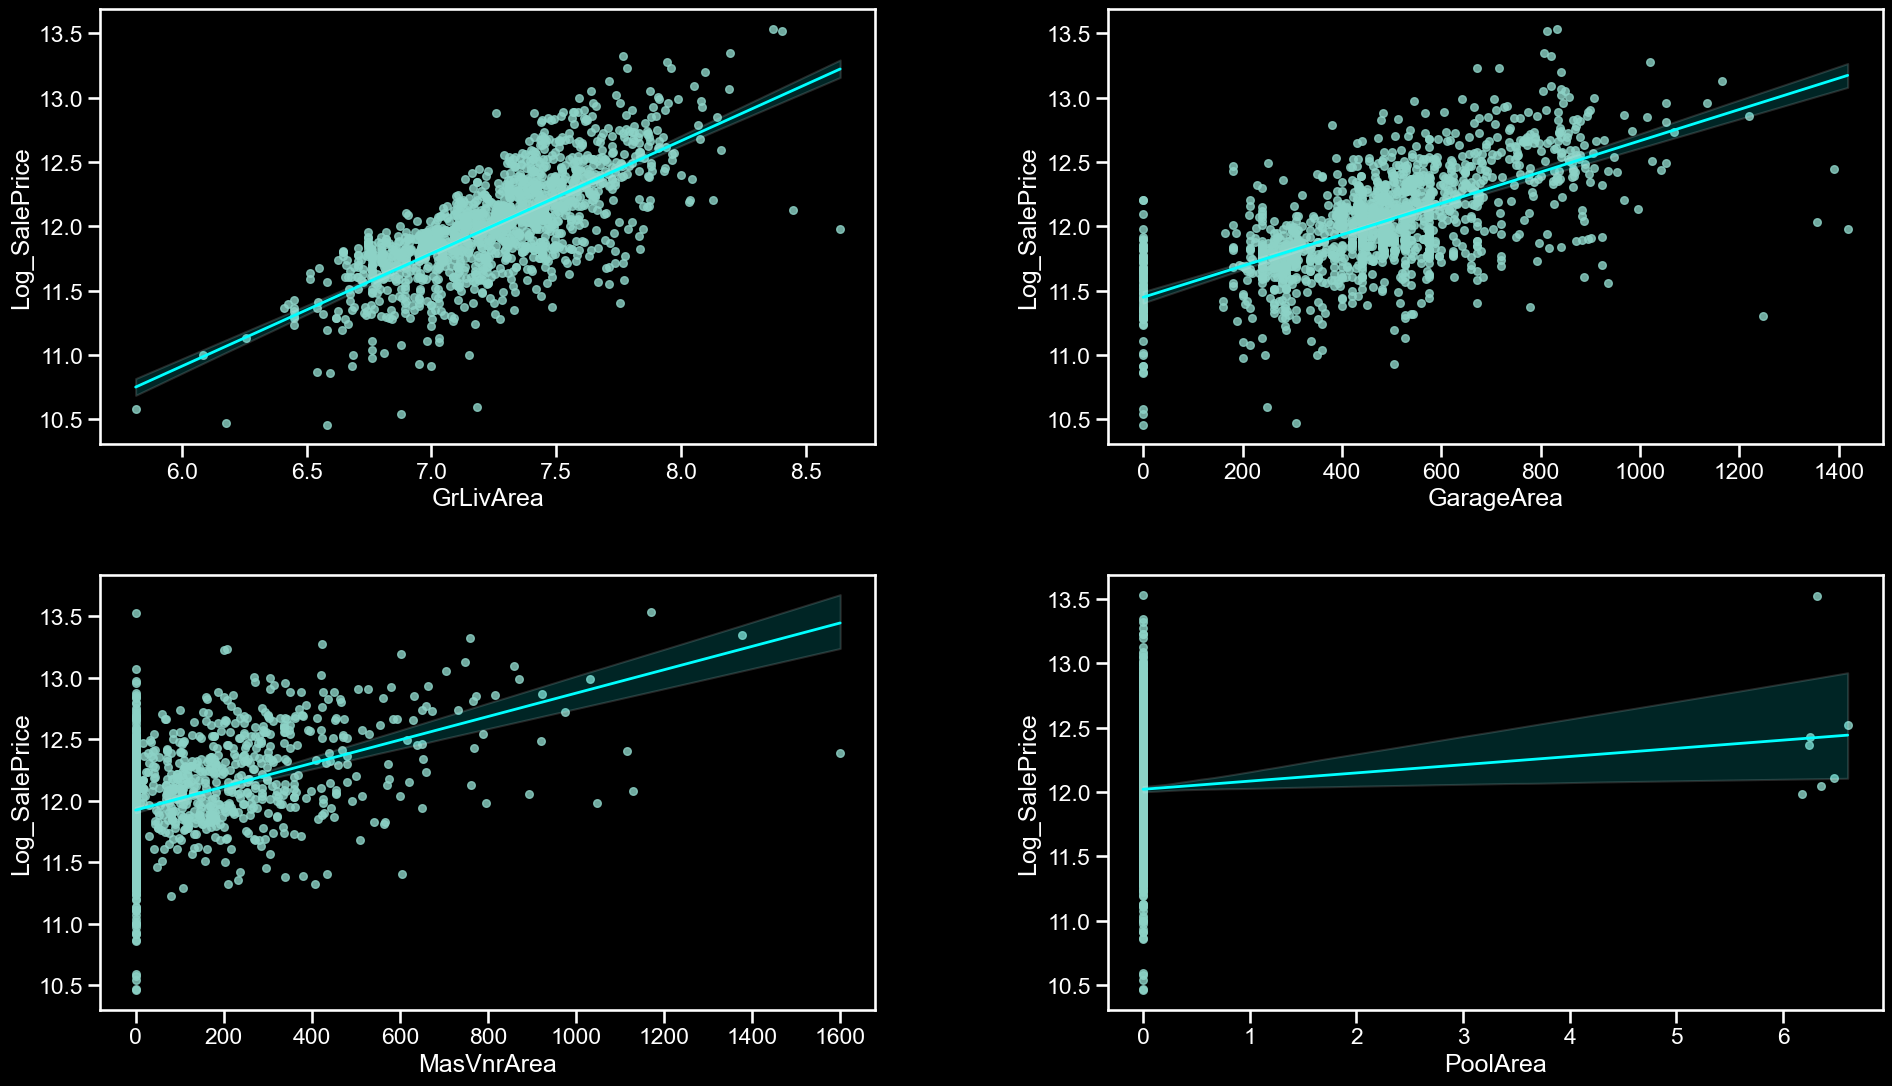

In [22]:
marker_size = 30
sns.set(style = 'ticks', context = 'talk', font_scale= 1)
plt.style.use("dark_background")

plt.figure(figsize=(23, 13))
plt.subplots_adjust(hspace = 0.3, wspace= 0.3)

plt.subplot(2,2,1)
sns.regplot(data = house_df, x = 'GrLivArea', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2})

plt.subplot(2,2,2)
sns.regplot(data = house_df, x = 'GarageArea', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2})

plt.subplot(2,2,3)
sns.regplot(data = house_df, x = 'MasVnrArea', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2})

plt.subplot(2,2,4)
sns.regplot(data = house_df, x = 'PoolArea', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2})

- OpenPorchSF & EnclosedPorch & 3SsnPorch & ScreenPorch

    - 4가지 종류의 현관중 OpenPorchSF와 SalePrice의 상관관계가 0.469로 가장 높다.

    - 3SsnPorch와 ScreenPorch 변수는 SalePrice의 관계와 관련 없는 것으로 보인다.

    - 4가지의 변수는 각 현관의 종류를 의미하며, 현관의 면적이 서로 연관될 가능성이 존재하기 때문에 SalePrice의 관계가 있는지 다른 관점에서 확인할 필요성이 있다.

        - 파생변수를 생성하여 SalePrice와 관계 재확인

Text(0.5, 1.0, 'corr: 0.094')

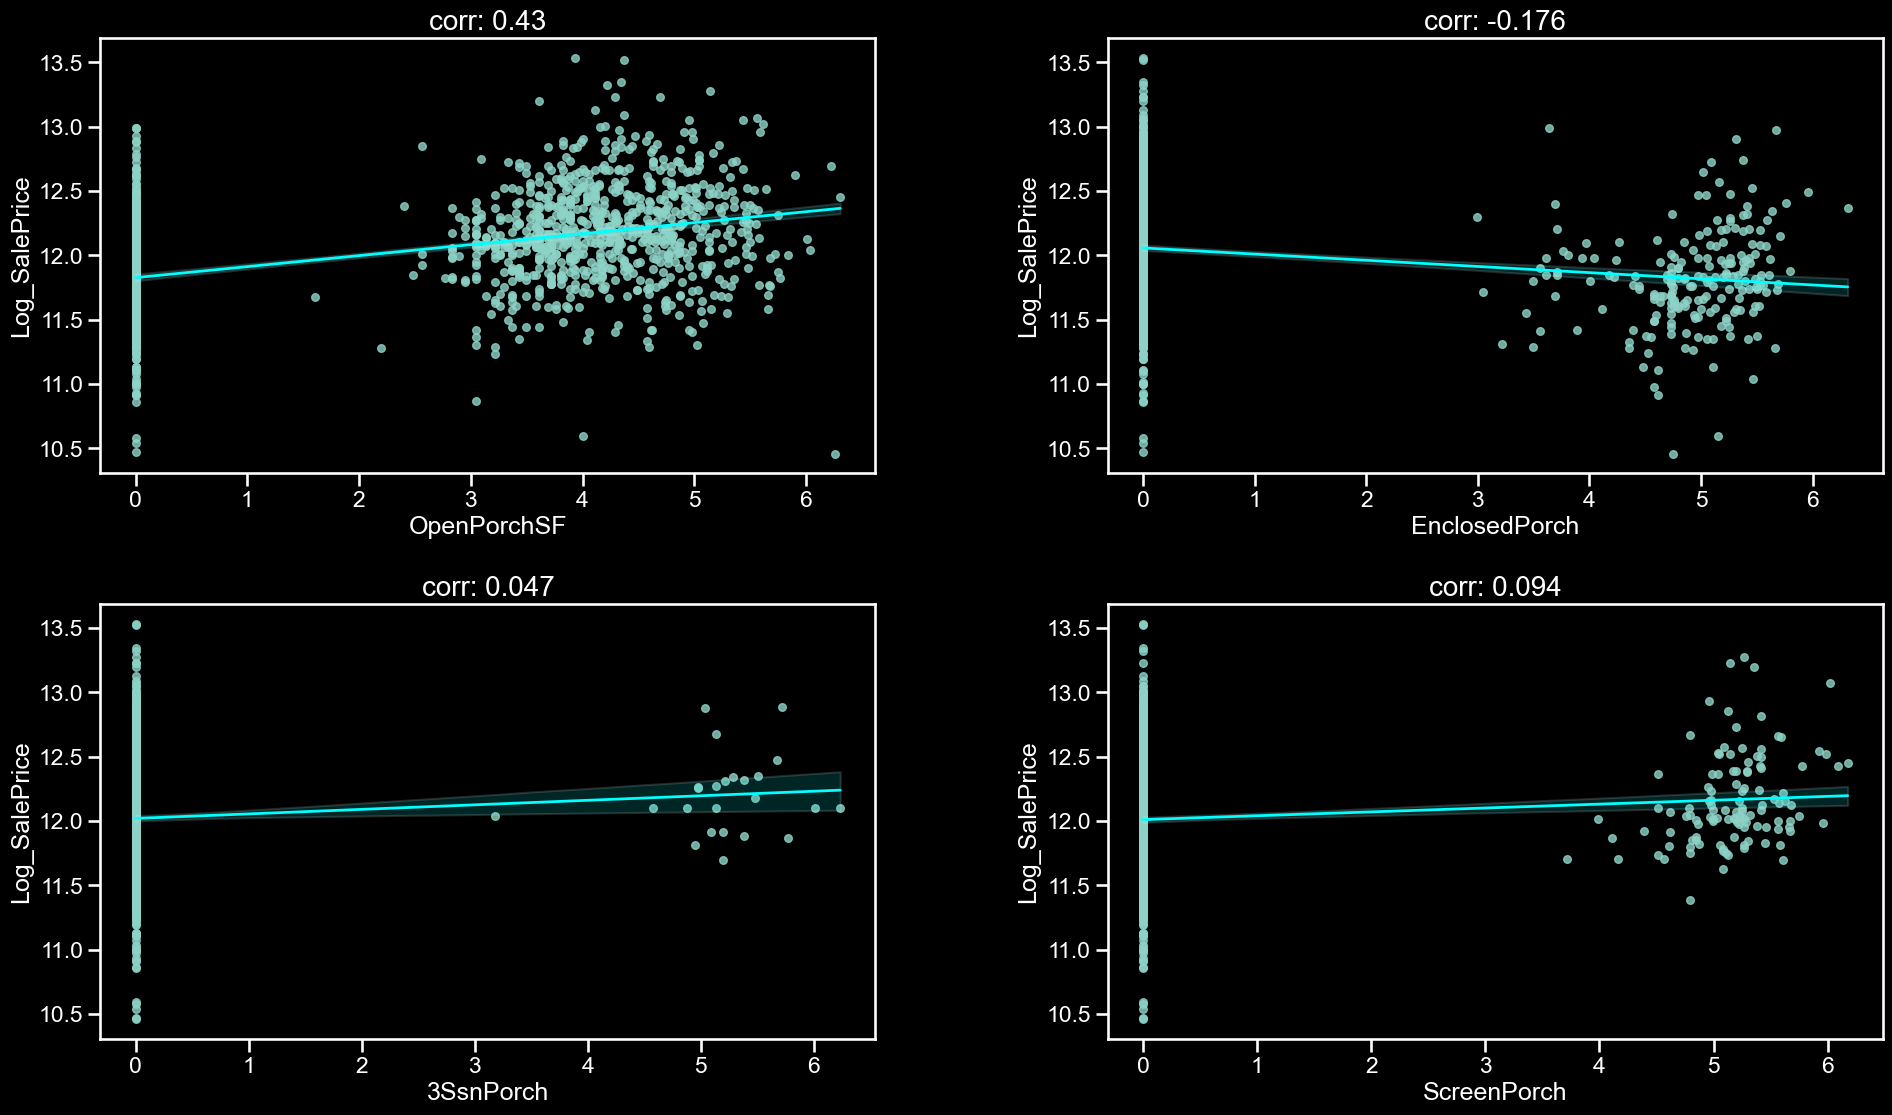

In [23]:
marker_size = 30
sns.set(style = 'ticks', context = 'talk', font_scale= 1)
plt.style.use("dark_background")

plt.figure(figsize=(23, 13))
plt.subplots_adjust(hspace = 0.3, wspace= 0.3)

plt.subplot(2,2,1)
ax1 = sns.regplot(data = house_df, x = 'OpenPorchSF', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2}, order =1)
ax1.set_title('corr: {}'.format(round(house_df["OpenPorchSF"].corr(house_df["SalePrice"]),3)),fontsize=20)

plt.subplot(2,2,2)
ax2 = sns.regplot(data = house_df, x = 'EnclosedPorch', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2}, order =1)
ax2.set_title('corr: {}'.format(round(house_df["EnclosedPorch"].corr(house_df["SalePrice"]),3)),fontsize=20)

plt.subplot(2,2,3)
ax3 = sns.regplot(data = house_df, x = '3SsnPorch', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2}, order =1)
ax3.set_title('corr: {}'.format(round(house_df["3SsnPorch"].corr(house_df["SalePrice"]),3)),fontsize=20)

plt.subplot(2,2,4)
ax4 = sns.regplot(data = house_df, x = 'ScreenPorch', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2}, order =1)
ax4.set_title('corr: {}'.format(round(house_df["ScreenPorch"].corr(house_df["SalePrice"]),3)),fontsize=20)

- WoodDeckSF
    
    - 데크 면적과 집의 관계는 0.337로 양의 관계에 있다.

Correlation Coefficient:0.343


<Axes: xlabel='WoodDeckSF', ylabel='Log_SalePrice'>

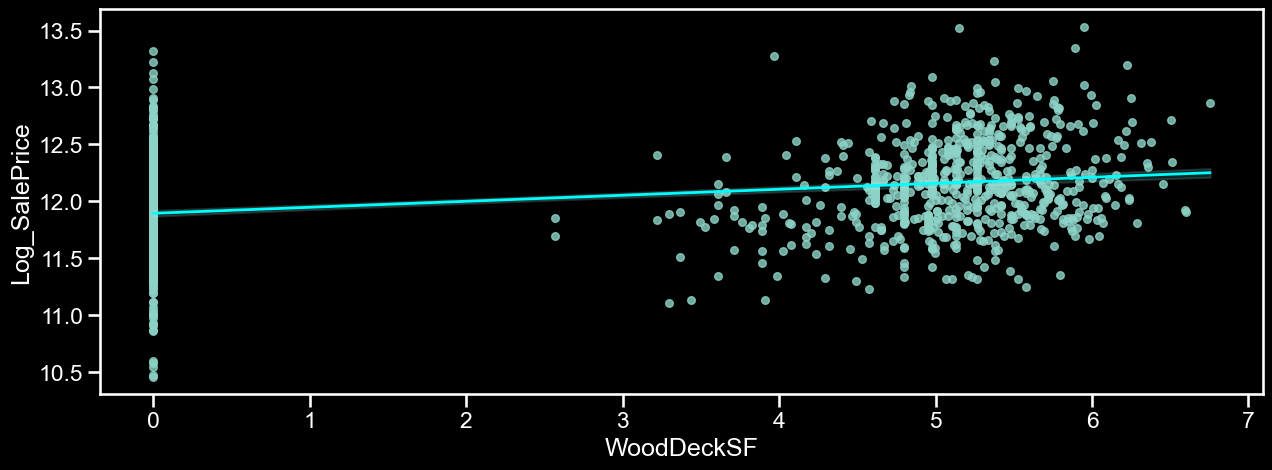

In [24]:
marker_size = 30
sns.set(style = 'ticks', context = 'talk', font_scale= 1)
plt.style.use("dark_background")

plt.figure(figsize=(15, 5))

coef = house_df["WoodDeckSF"].corr(house_df["Log_SalePrice"])
print(f"Correlation Coefficient:{round(coef,3)}")
sns.regplot(data = house_df, x = 'WoodDeckSF', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2}, order = 1)

- LotArea
    
    - 땅의 면적을 말하며, 땅의 면적과 집의 가격은 양의 관계에 있다.

Correlation Coefficient:0.4


<Axes: xlabel='LotArea', ylabel='Log_SalePrice'>

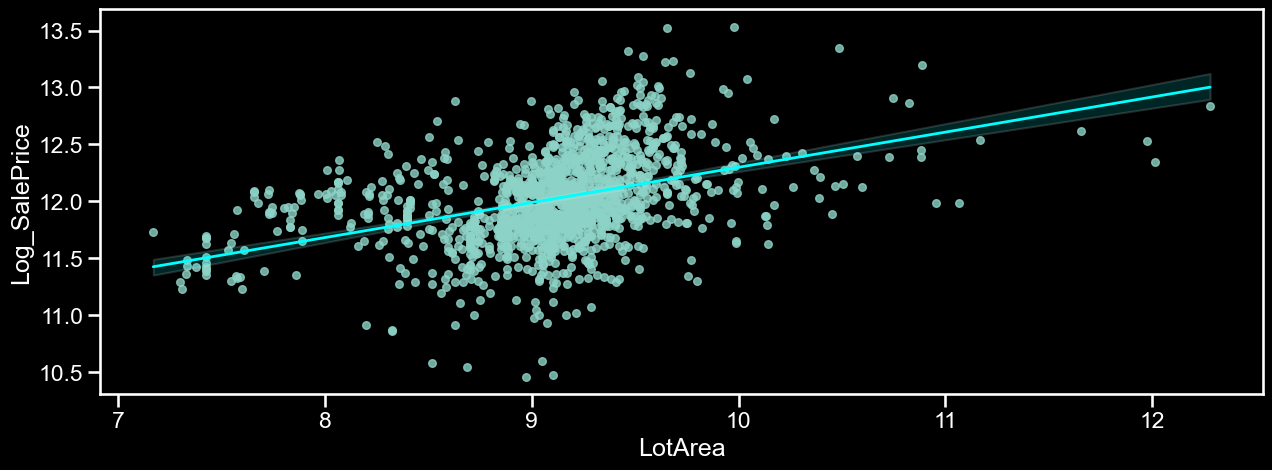

In [25]:
marker_size = 30
sns.set(style = 'ticks', context = 'talk', font_scale= 1)
plt.style.use("dark_background")

plt.figure(figsize=(15, 5))

coef = house_df["LotArea"].corr(house_df["Log_SalePrice"])
print(f"Correlation Coefficient:{round(coef,3)}")
sns.regplot(data = house_df, x = 'LotArea', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2},order = 1)

- MiscVal

    - 기타 기능을 말하며, SalePrice의 관계와 관련없는 것으로 보인다.

Correlation Coefficient:-0.067


<Axes: xlabel='MiscVal', ylabel='Log_SalePrice'>

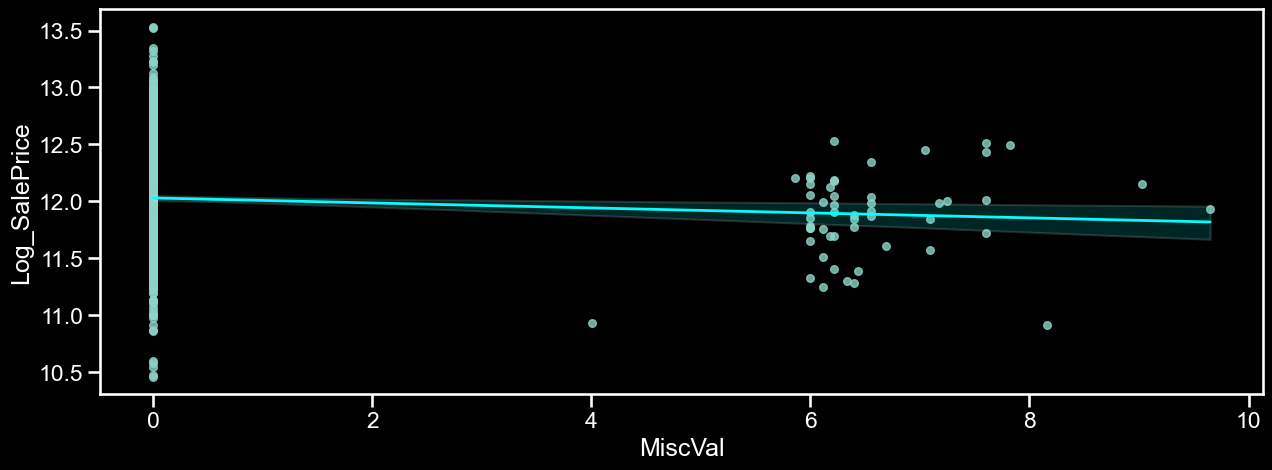

In [26]:
marker_size = 30
sns.set(style = 'ticks', context = 'talk', font_scale= 1)
plt.style.use("dark_background")

plt.figure(figsize=(15, 5))

coef = house_df["MiscVal"].corr(house_df["Log_SalePrice"])
print(f"Correlation Coefficient:{round(coef,3)}")
sns.regplot(data = house_df, x = 'MiscVal', y = 'Log_SalePrice', scatter_kws={'s': marker_size}, line_kws={"color": 'cyan', "lw": 2})